# AIPI 590 - XAI | Mechanistic Interpretability
### A tiny neural network for XOR classification
### Mariam Khan

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mkhan13/XAI/blob/main/mechanistic_interpretability.ipynb
)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# **Part 1 - Setup**

### Data Generation

In [2]:
X = torch.tensor([[0,0],[0,1],[1,0],[1,1]], dtype=torch.float32)
y = torch.tensor([[0],[1],[1],[0]], dtype=torch.float32)

### Build a Tiny MLP (multilayer perceptron) Model

In [3]:
class TinyXOR(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(2, 2)
        self.out = nn.Linear(2, 1)
        self.act = nn.Sigmoid()

    def forward(self, x):
        h = torch.sigmoid(self.hidden(x))
        yhat = torch.sigmoid(self.out(h))
        return yhat, h

model = TinyXOR()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

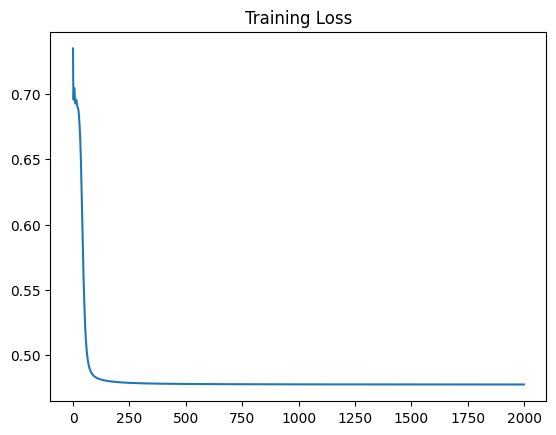

In [4]:
# Train
losses = []
for epoch in range(2000):
    optimizer.zero_grad()
    yhat, _ = model(X)
    loss = criterion(yhat, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(losses)
plt.title("Training Loss")
plt.show()

In [7]:
# Test predictions
with torch.no_grad():
    pred, hidden = model(X)
print(torch.round(pred))

tensor([[0.],
        [1.],
        [1.],
        [1.]])


# **Part 2 - Explore**

# **Part 3 - Explain**

# **Part 4 - Reflect**